# Final Project
Names: Kenneth Samaniego and Sophia Nguyen

## Imports

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import resample

# TEST TO LOAD DATASET
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Part 1: Preprocessing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


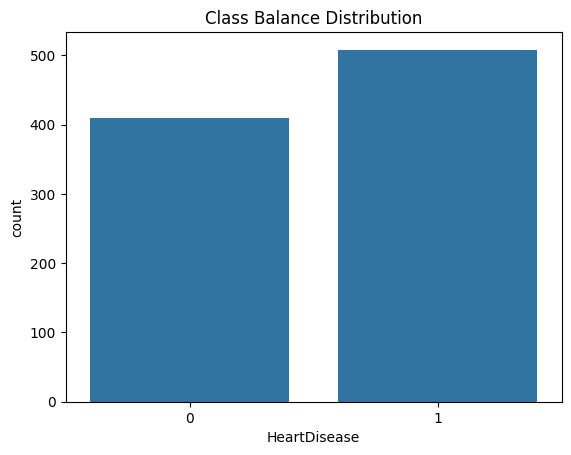

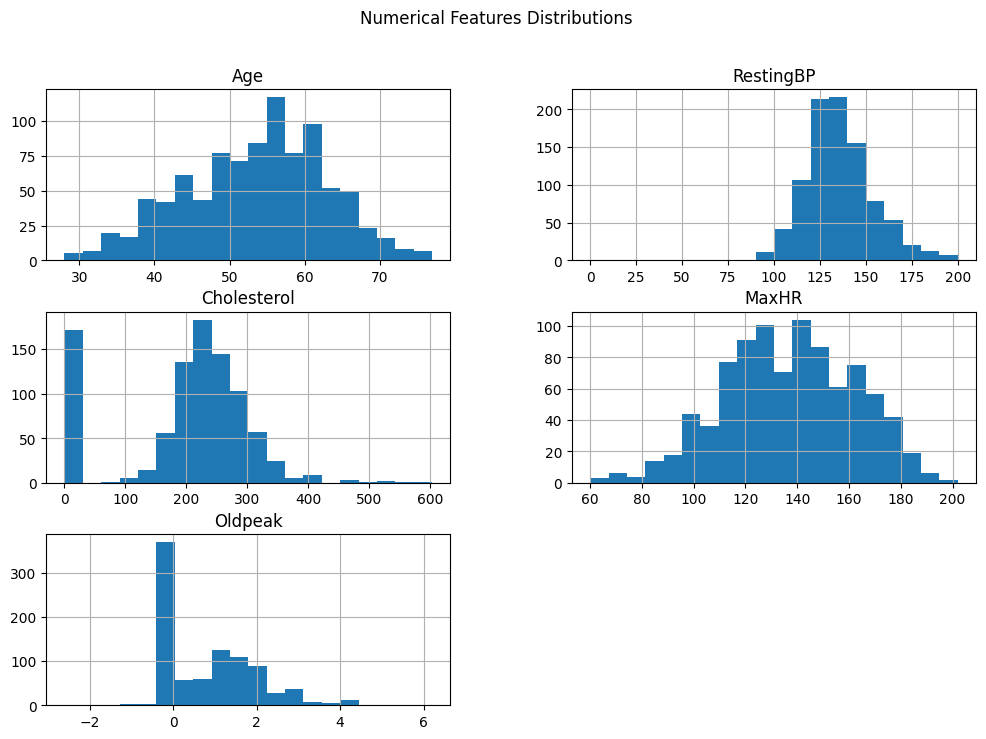

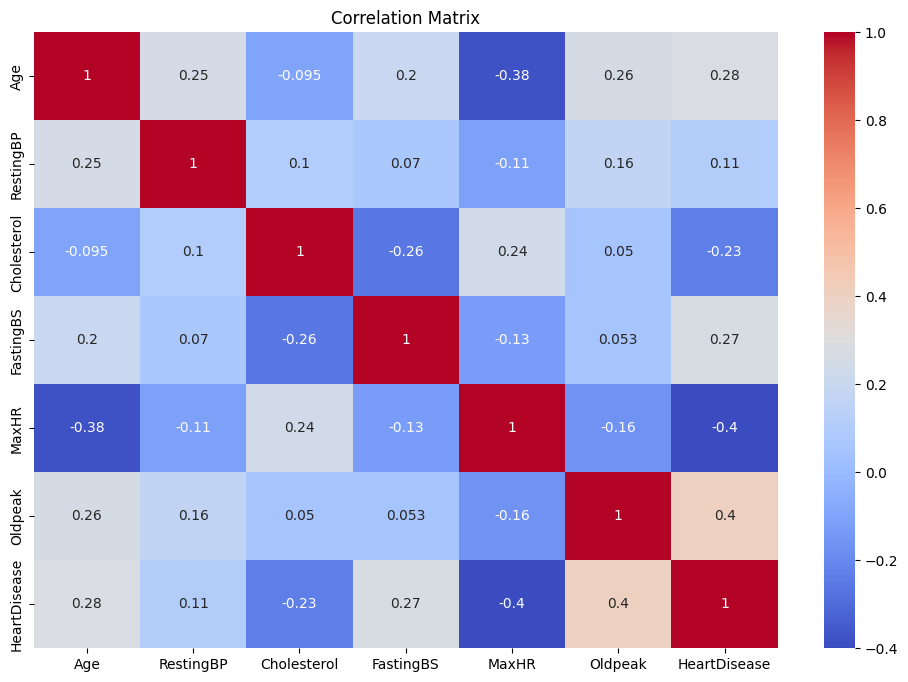

Missing values:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64
Class distribution before splitting: HeartDisease
1    508
0    410
Name: count, dtype: int64
Train class distribution: HeartDisease
1    406
0    328
Name: count, dtype: int64


In [2]:
# EDA =================================
df.info() #general info
df.describe(include='all') # stats

#checking for class balance
sns.countplot(x='HeartDisease', data=df)
plt.title('Class Balance Distribution')
plt.show()

# Distributions for numerical features (age, restingbp, cholestrerol, etc.)
features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
df[features].hist(figsize=(12,8), bins=20)
plt.suptitle('Numerical Features Distributions')
plt.show()

#correlations
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Missing vals & outliers =================================
print('Missing values:')
print(df.isnull().sum()) # check for missing values (aka NULL)

#handle missing/zeroes in Cholesterol & Resting BP values since those physically can't be 0
for i in ['Cholesterol', 'RestingBP']:
    df[i] = df[i].replace(0, np.nan) #replaces 0's w/ NaN's
    df[i] = df[i].fillna(df[i].median())

#handle outliers (w/ IQR)
for i in features:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3- Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[i] = np.where(df[i] < lower, lower, np.where(df[i] > upper, upper, df[i]))

# Encode categorical variables =================================
df['Sex'] = df['Sex'].map({'M':1, 'F': 0})
df['ExerciseAngina'] = df['ExerciseAngina'].map({'Y': 1, 'N': 0})

# multiclass categorical variable
df = pd.get_dummies(df, columns=['ChestPainType', 'RestingECG', 'ST_Slope'], drop_first=True)

# Normalize =================================
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Training set & testing set =================================
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

print(f'Class distribution before splitting: {y.value_counts()}') # FOR CHECKING CLASS BALANCE

#the actual splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(f'Train class distribution: {y_train.value_counts()}') #CHECK BALANCE AFTER SPLIT

In [3]:
# Check imbalance =================================
temp = pd.concat([X_train, y_train], axis=1)

print(f"Checking imbalance: {temp['HeartDisease'].value_counts()}")
# outputs:
    #Class 1 (Heart Disease): 406 (~55.3%)
    #CLass 0 (No Disease) : 328 (~44.7)
# Means it's a mild class imbalance

# tackling data imbalance =====
train_df = pd.concat([X_train, y_train], axis=1) #combine X_train & y_train to resample

#separate major & minor classes
majority = train_df[train_df.HeartDisease == 1]
minority = train_df[train_df.HeartDisease == 0]

#upsample minority
minority_upsample = resample(minority, replace=True, n_samples=len(majority), random_state=42)

train_balanced = pd.concat([majority, minority_upsample]) #combine back
#shuffle & split
X_train_balanced = train_balanced.drop('HeartDisease', axis=1)
y_train_balanced = train_balanced['HeartDisease']

#check new class balance
print(f'Balanced training set: {y_train_balanced.value_counts()}')

Checking imbalance: HeartDisease
1    406
0    328
Name: count, dtype: int64
Balanced training set: HeartDisease
1    406
0    406
Name: count, dtype: int64


## Part 2: Model Design and Training

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "Support Vector Machine": SVC(probability=True),  # set probability=True to use predict_proba
    "Neural Network": MLPClassifier(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

def train_model(X_train, y_train, X_test, y_test, models, clock=False, return_summary=False):
    '''Returns a list of [dict, dict, list]: [results, times, summary]
       if clock = True, then will show times
       if return_summary = True, then will collect metrics summary'''
    
    results = {}
    times = {}
    summary = []
    
    for name, model in models.items():
        if clock:
            start_time = time.time()
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        elapsed_time = time.time() - start_time if clock else None
        if clock:
            times[name] = {'Time elapsed': round(elapsed_time, 4)}
        
        if return_summary:
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred)
            rec = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc = roc_auc_score(y_test, y_proba)

            summary.append({
                'Model': name,
                'Accuracy': acc,
                'Precision': prec,
                'Recall': rec,
                'F1 Score': f1,
                'ROC AUC': roc,
                'Inference Time (s)': round(elapsed_time, 4) if clock else None
            })

        print(f"\n{name} Results:")
        cmatrix = (confusion_matrix(y_test, y_pred))
        plt.figure(figsize=(3, 2))
        sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Greens')
        plt.title(f'{name} - Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.tight_layout()
        plt.show()
        print(classification_report(y_test, y_pred))
        print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba)}")
        if clock:
            print(f"Inference Time: {elapsed_time:.4f} seconds")
        
        results[name] = {
            'conf_matrix': confusion_matrix(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred, output_dict=True),
            'roc_auc': roc_auc_score(y_test, y_proba)
        }


    return [results, times, summary]


Logistic Regression Results:


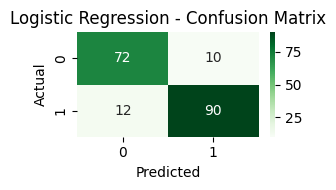

              precision    recall  f1-score   support

           0       0.86      0.88      0.87        82
           1       0.90      0.88      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184

ROC AUC Score: 0.9231229076996652
Inference Time: 0.0120 seconds

Decision Tree Results:


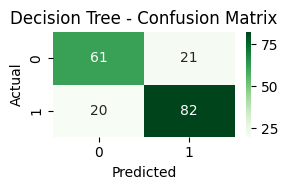

              precision    recall  f1-score   support

           0       0.75      0.74      0.75        82
           1       0.80      0.80      0.80       102

    accuracy                           0.78       184
   macro avg       0.77      0.77      0.77       184
weighted avg       0.78      0.78      0.78       184

ROC AUC Score: 0.7739120038259206
Inference Time: 0.0040 seconds

Naive Bayes Results:


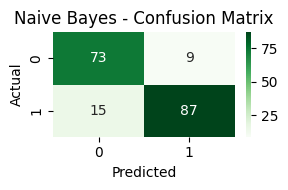

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        82
           1       0.91      0.85      0.88       102

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184

ROC AUC Score: 0.9408177905308465
Inference Time: 0.0030 seconds

Support Vector Machine Results:


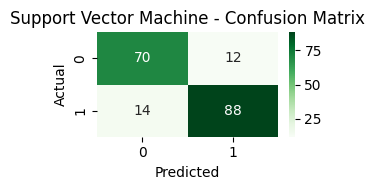

              precision    recall  f1-score   support

           0       0.83      0.85      0.84        82
           1       0.88      0.86      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

ROC AUC Score: 0.9240793878527022
Inference Time: 0.0460 seconds

Neural Network Results:


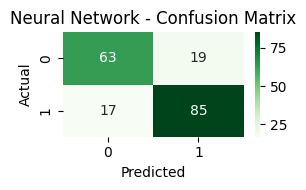

              precision    recall  f1-score   support

           0       0.79      0.77      0.78        82
           1       0.82      0.83      0.83       102

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.80      0.80      0.80       184

ROC AUC Score: 0.880439980870397
Inference Time: 1.8210 seconds

Random Forest Results:


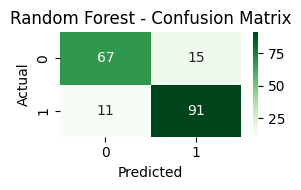

              precision    recall  f1-score   support

           0       0.86      0.82      0.84        82
           1       0.86      0.89      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.85      0.86       184
weighted avg       0.86      0.86      0.86       184

ROC AUC Score: 0.9169057867049258
Inference Time: 0.0800 seconds

AdaBoost Results:


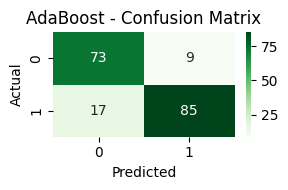

              precision    recall  f1-score   support

           0       0.81      0.89      0.85        82
           1       0.90      0.83      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

ROC AUC Score: 0.911166905786705
Inference Time: 0.0470 seconds

=== Summary Metrics ===
                    Model  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
0     Logistic Regression  0.880435   0.900000  0.882353  0.891089  0.923123   
2             Naive Bayes  0.869565   0.906250  0.852941  0.878788  0.940818   
5           Random Forest  0.858696   0.858491  0.892157  0.875000  0.916906   
3  Support Vector Machine  0.858696   0.880000  0.862745  0.871287  0.924079   
6                AdaBoost  0.858696   0.904255  0.833333  0.867347  0.911167   
4          Neural Network  0.804348   0.817308  0.833333  0.825243  0.880440   
1           Decision Tre

In [5]:
results, times, summary = train_model(X_train_balanced, y_train_balanced, X_test, y_test, models, clock=True, return_summary=True)

# Convert summary to DataFrame
summary_df = pd.DataFrame(summary)
# Sort and visualize
summary_df = summary_df.sort_values(by= 'F1 Score' , ascending=False)

print('\n=== Summary Metrics ===')
print(summary_df)

## Part 3: Model Improvements

### Hyperparameter Tuning

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score

# Decision Tree
param_grid_dt = {
    'max_depth': [3, 5, 10, None],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5, n_jobs=-1)
grid_dt.fit(X_train_balanced, y_train_balanced)
print("Best Decision Tree Params:", grid_dt.best_params_)

# SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
grid_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, n_jobs=-1)
grid_svm.fit(X_train_balanced, y_train_balanced)
print("Best SVM Params:", grid_svm.best_params_)

# Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # Supports both l1 and l2
}
grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, n_jobs=-1)
grid_lr.fit(X_train_balanced, y_train_balanced)
print("Best Logistic Regression Params:", grid_lr.best_params_)


# MLP Classifier
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'solver': ['adam'],
    'learning_rate': ['constant', 'adaptive']
}
grid_mlp = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True), param_grid_mlp, cv=5, n_jobs=-1)
grid_mlp.fit(X_train_balanced, y_train_balanced)
print("Best MLP Params:", grid_mlp.best_params_)

# Naive Bayes
param_grid_nb = {'var_smoothing': [1e-9, 1e-8, 1e-7]}
grid_nb = GridSearchCV(GaussianNB(), param_grid_nb, cv=5)
grid_nb.fit(X_train_balanced, y_train_balanced)
print("Best Naive Bayes Params:", grid_nb.best_params_)

#random forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],            # Number of trees in the forest
    'max_depth': [5, 10, 20, None],            # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],           # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],             # Minimum samples at each leaf
    'criterion': ['gini', 'entropy']           # Function to measure the quality of a split
}

grid_rf = GridSearchCV(
    RandomForestClassifier(),
    param_grid_rf,
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_rf.fit(X_train_balanced, y_train_balanced)
print("Best Random Forest Params:", grid_rf.best_params_)



Best Decision Tree Params: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best SVM Params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best Logistic Regression Params: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best MLP Params: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best Naive Bayes Params: {'var_smoothing': 1e-09}
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Random Forest Params: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}



Decision Tree (Improved) Results:


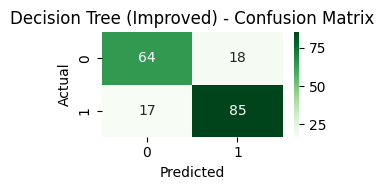

              precision    recall  f1-score   support

           0       0.79      0.78      0.79        82
           1       0.83      0.83      0.83       102

    accuracy                           0.81       184
   macro avg       0.81      0.81      0.81       184
weighted avg       0.81      0.81      0.81       184

ROC AUC Score: 0.8069105691056911
Inference Time: 0.0030 seconds

SVM (Improved) Results:


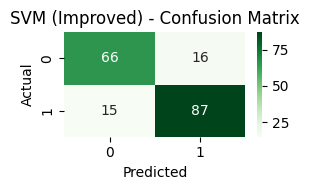

              precision    recall  f1-score   support

           0       0.81      0.80      0.81        82
           1       0.84      0.85      0.85       102

    accuracy                           0.83       184
   macro avg       0.83      0.83      0.83       184
weighted avg       0.83      0.83      0.83       184

ROC AUC Score: 0.9056671449067432
Inference Time: 0.0470 seconds

Logistic Regression (Improved) Results:


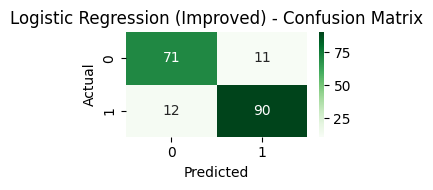

              precision    recall  f1-score   support

           0       0.86      0.87      0.86        82
           1       0.89      0.88      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184

ROC AUC Score: 0.9219273075083692
Inference Time: 0.0020 seconds

MLP (Improved) Results:


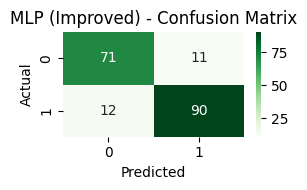

              precision    recall  f1-score   support

           0       0.86      0.87      0.86        82
           1       0.89      0.88      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184

ROC AUC Score: 0.9200143472022955
Inference Time: 0.1168 seconds

Naive Bayes (Improved) Results:


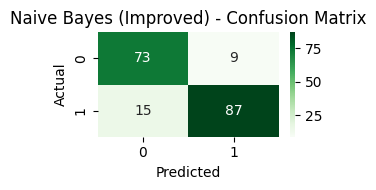

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        82
           1       0.91      0.85      0.88       102

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184

ROC AUC Score: 0.9408177905308465
Inference Time: 0.0020 seconds

Random Forest (Improved) Results:


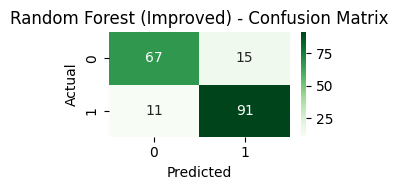

              precision    recall  f1-score   support

           0       0.86      0.82      0.84        82
           1       0.86      0.89      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.85      0.86       184
weighted avg       0.86      0.86      0.86       184

ROC AUC Score: 0.9241989478718315
Inference Time: 0.1560 seconds

=== Tuned Model Summary Matrix ===
                            Model  Accuracy  Precision    Recall  F1 Score  \
2  Logistic Regression (Improved)  0.875000   0.891089  0.882353  0.886700   
3                  MLP (Improved)  0.875000   0.891089  0.882353  0.886700   
4          Naive Bayes (Improved)  0.869565   0.906250  0.852941  0.878788   
5        Random Forest (Improved)  0.858696   0.858491  0.892157  0.875000   
1                  SVM (Improved)  0.831522   0.844660  0.852941  0.848780   
0        Decision Tree (Improved)  0.809783   0.825243  0.833333  0.829268   

    ROC AUC  Inference Ti

In [8]:
models_tuned = {
    'Decision Tree (Improved)': grid_dt.best_estimator_,
    'SVM (Improved)': grid_svm.best_estimator_,
    'Logistic Regression (Improved)': grid_lr.best_estimator_,
    'MLP (Improved)': grid_mlp.best_estimator_,
    'Naive Bayes (Improved)': grid_nb.best_estimator_,
    'Random Forest (Improved)': grid_rf.best_estimator_,
}

results_tuned, times_tuned, summary_tuned = train_model( 
    X_train_balanced, y_train_balanced, X_test, y_test, models = models_tuned,clock=True,return_summary=True,)


# Convert summary to DataFrame for tuned models
summary_tuned_df = pd.DataFrame(summary_tuned)

# Sort by 'F1 Score' (or any other metric you'd like) for tuned models
summary_tuned_df_sorted = summary_tuned_df.sort_values(by='F1 Score', ascending=False)

print('\n=== Tuned Model Summary Matrix ===')
print(summary_tuned_df_sorted)


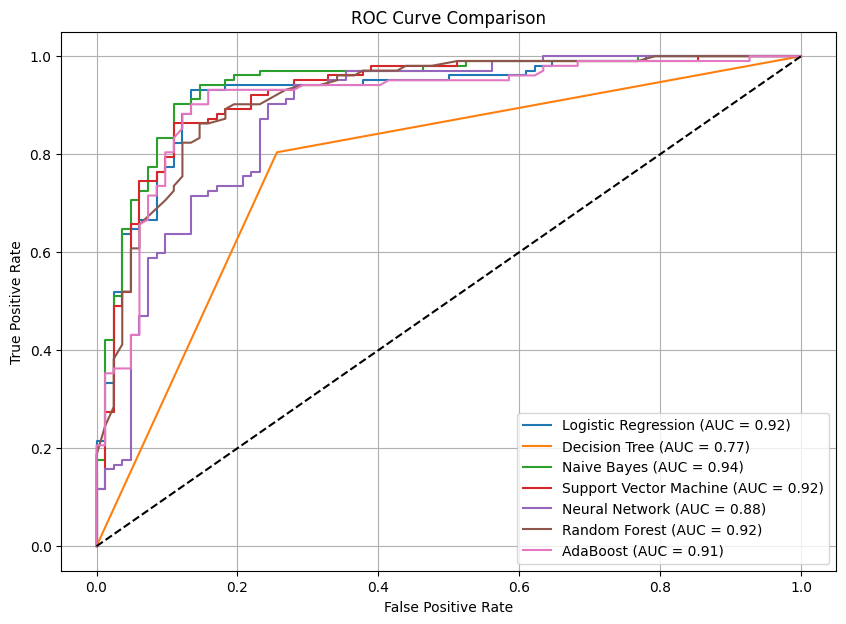

In [9]:
from sklearn.metrics import roc_curve, auc

# ROC Curve Plot
plt.figure(figsize=(10, 7))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()

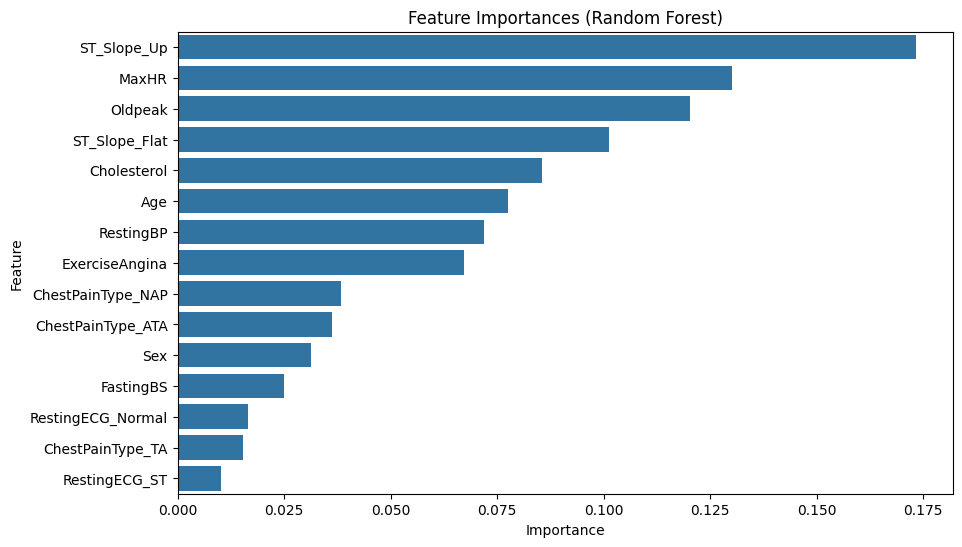

In [10]:
# Feature importance from Random Forest
importances = models['Random Forest'].feature_importances_
feat_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_imp_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Feature Importances (Random Forest)')
plt.show()

## Part 4: Model Comparison and Interpretation


=== Original Model Summary Matrix ===
                    Model  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
0     Logistic Regression  0.880435   0.900000  0.882353  0.891089  0.923123   
2             Naive Bayes  0.869565   0.906250  0.852941  0.878788  0.940818   
5           Random Forest  0.858696   0.858491  0.892157  0.875000  0.916906   
3  Support Vector Machine  0.858696   0.880000  0.862745  0.871287  0.924079   
6                AdaBoost  0.858696   0.904255  0.833333  0.867347  0.911167   
4          Neural Network  0.804348   0.817308  0.833333  0.825243  0.880440   
1           Decision Tree  0.777174   0.796117  0.803922  0.800000  0.773912   

   Inference Time (s)  
0               0.012  
2               0.003  
5               0.080  
3               0.046  
6               0.047  
4               1.821  
1               0.004  

=== Tuned Model Summary Matrix ===
                            Model  Accuracy  Precision    Recall  F1 Score  \
2  Logistic Re

C:\Users\Kenneth Samaniego\AppData\Local\Temp\ipykernel_51600\380607264.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1 Score', y='Model', data=summary_df_sorted, palette='crest')


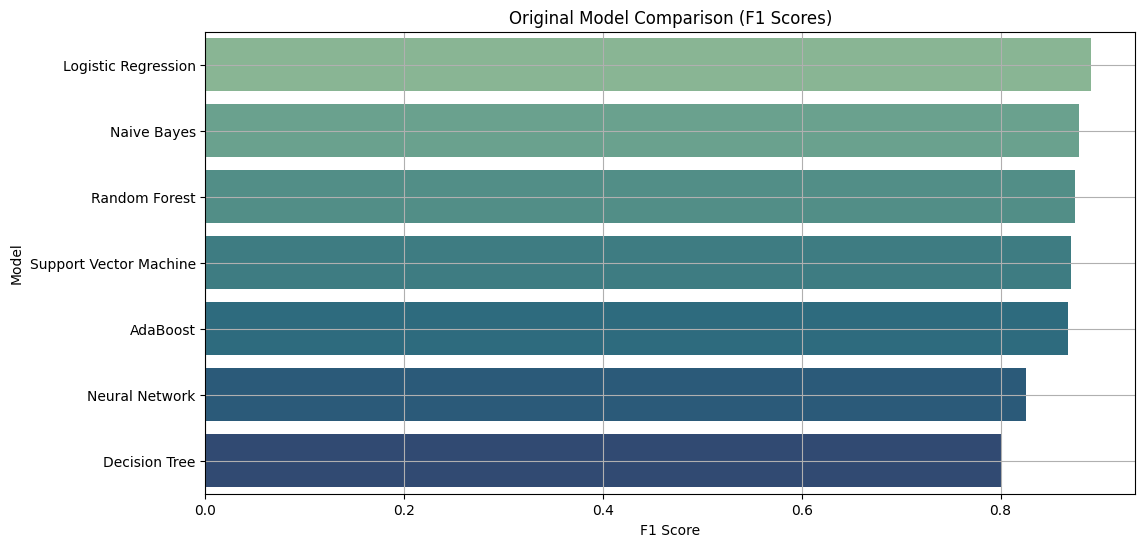

C:\Users\Kenneth Samaniego\AppData\Local\Temp\ipykernel_51600\380607264.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1 Score', y='Model', data=summary_tuned_df_sorted, palette='crest')


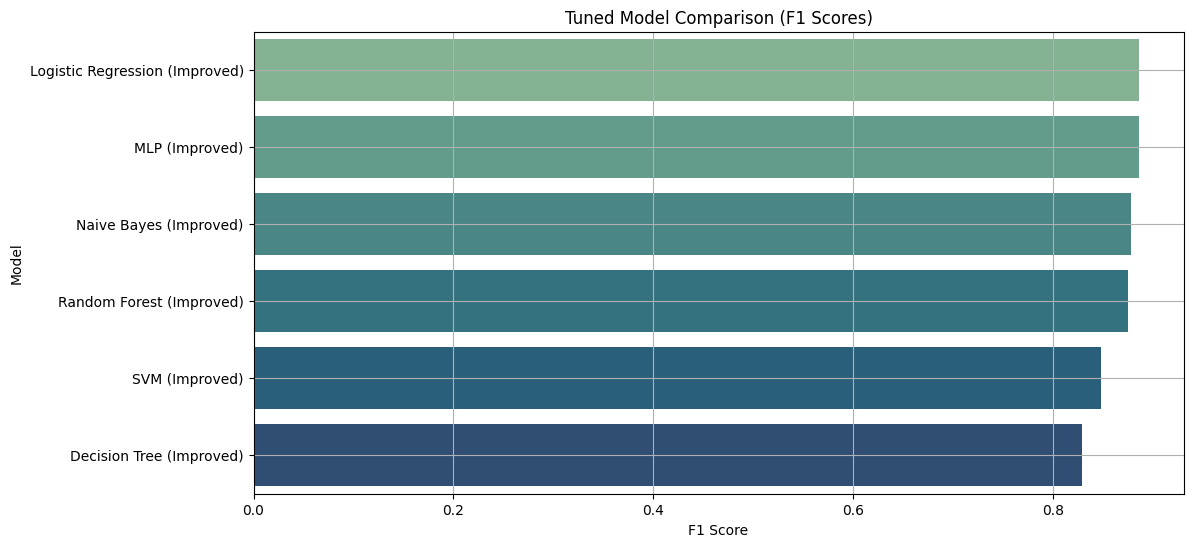

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert summary to DataFrame for original models
summary_df = pd.DataFrame(summary)

# Convert summary to DataFrame for tuned models
summary_tuned_df = pd.DataFrame(summary_tuned)

# Sort by 'F1 Score' (or any other metric you'd like) for original models
summary_df_sorted = summary_df.sort_values(by='F1 Score', ascending=False)

# Sort by 'F1 Score' (or any other metric you'd like) for tuned models
summary_tuned_df_sorted = summary_tuned_df.sort_values(by='F1 Score', ascending=False)

# Print the summary matrices for both original and tuned models
print('\n=== Original Model Summary Matrix ===')
print(summary_df_sorted)

print('\n=== Tuned Model Summary Matrix ===')
print(summary_tuned_df_sorted)

# Plot a bar graph comparing F1 scores for original models
plt.figure(figsize=(12, 6))
sns.barplot(x='F1 Score', y='Model', data=summary_df_sorted, palette='crest')
plt.title('Original Model Comparison (F1 Scores)')
plt.grid(True)
plt.show()

# Plot a bar graph comparing F1 scores for tuned models
plt.figure(figsize=(12, 6))
sns.barplot(x='F1 Score', y='Model', data=summary_tuned_df_sorted, palette='crest')
plt.title('Tuned Model Comparison (F1 Scores)')
plt.grid(True)
plt.show()